
# Comparação de Performance: Dijkstra Clássico vs Dijkstra com Min-Heap



## Objetivo



Avaliar **tempo de execução** e **pegada de carbono (CO₂)** das seguintes abordagens de caminho mínimo:
- **Dijkstra Clássico** (`O(V² + E)`), conforme implementado em sala;
- **Dijkstra com Min-Heap** (`O((V + E) * log V)`), conforme implementado em sala;

> **Obrigatório**: reutilizar as **versões das aulas** (`dijsktra.ipynb` e `dijsktra_min_heap.ipynb`). Ajustes menores são permitidos (p.ex., medições, modularização, execução), sem mudar a lógica.




## Descrição do Problema



Você deverá:
1. Gerar **grafos ponderados e conectados** com o `networkx` em diferentes tamanhos, **indo até 100.000 nós** (ou o máximo suportado pela sua máquina).
2. Para cada grafo, escolher **5 nós aleatórios** e calcular o **caminho mínimo** desses nós para **todos os demais nós** usando:
   - A versão **clássica** de Dijkstra;
   - A versão **com Min-Heap**;
   - A função de **referência** do `networkx`.
3. Repetir o experimento **15 a 20 vezes por tamanho** (trocando os 5 nós a cada repetição) para robustez estatística.
4. Medir e registrar para cada execução:
   - **Tempo** (s);
   - **CO₂** com [CodeCarbon](https://github.com/mlco2/codecarbon).
5. Calcular Intervalos de Confiança para as médias de tempo e CO₂.
6. Gerar **gráficos** e **tabelas** comparativas e **salvá-los no repositório**.





### Configuração Experimental


- Tamanhos sugeridos: `[100, 500, 1_000, 5_000, 10_000, 50_000, 100_000]`.
- **Reprodutibilidade**: fixe sementes (`numpy` e `random`).
- Geração de grafos: `nx.gnp_random_graph(n, p)` com pesos inteiros positivos (ex.: `1..10`).  
  Garanta conectividade (ex.: use o **componente gigante** quando necessário).
- **15–20 repetições** por tamanho; **5 fontes** por repetição.
- Evite travamentos validando primeiro em tamanhos menores.


### Métricas e Estatística



Nesta etapa, você vai transformar os dados brutos coletados (tempos e emissões de CO₂ de cada execução) em informações **estatisticamente interpretáveis**.  
O objetivo é comparar o desempenho dos algoritmos a partir das **médias** e **desvios-padrão** das execuções.


Para cada par **(tamanho do grafo, algoritmo)**, calcule:

| Métrica | Símbolo | Descrição |
|----------|----------|-----------|
| Média | \\(\bar{x}\\) | Tempo médio (ou CO₂ médio) das execuções |
| Desvio-padrão | \\(s\\) | Mede a variação dos resultados em torno da média |


Para cada algoritmo e tamanho de grafo, plote:

- **Eixo X:** número de nós do grafo  
- **Eixo Y:** tempo médio (ou CO₂ médio)  
- **Uma linha para cada algoritmo**  
- **Barras verticais** indicando a variação (\\(\bar{x} \pm s\\))







##Entregáveis




- **Repositório GitHub** contendo:
  - Notebook `.ipynb` com código, análises, **gráficos salvos** (`.png`/`.svg`) e tabelas (`.csv`);
  - `README.md` explicando metodologia, resultados e **link do vídeo**;
  - Vídeo (até 10min) Explique rapidamente os algoritmos, mostre a execução, apresente gráficos e discuta resultados. Sugestão de ferramentas (Loom e Youtube).
  - Organização clara e reprodutível (seções, funções, seeds).




## Avaliação (3 pts – Unidade 2)




| Critério | Descrição | Peso |
|---|---|---|
| Organização e reprodutibilidade | Estrutura limpa, README completo, seeds e scripts | 1.0 |
| Correção e **reutilização** das versões de sala | Aderência às implementações solicitadas | 1.0 |
| Análise e apresentação | Interpretação dos resultados, gráficos e vídeo | 1.0 |

**Individual ou em dupla.**


## Exemplos de código

In [1]:
!pip install codecarbon
!pip install networkx pandas seaborn matplotlib codecarbon scipy tqdm

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import random
import time
import os
import sys
from tqdm.notebook import tqdm  # Usar tqdm.notebook para o Colab
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from codecarbon import EmissionsTracker # Usar o tracker Online para o Colab
import warnings

# Suprimir avisos comuns do seaborn/matplotlib
warnings.filterwarnings('ignore')

In [4]:
# O(V^2 + E) time | O(V) space
def dijkstra_classic_algorithm(start, edges):
    """
    Implementação Clássica do Dijkstra.
    """
    numberOfVertices = len(edges)
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0
    visited = set()

    while len(visited) != numberOfVertices:
        vertex, currentMinDistance = getVertexWithMinDistance(minDistances, visited)
        if currentMinDistance == float("inf"):
            break
        visited.add(vertex)
        for edge in edges[vertex]:
            destination, distanceToDestination = edge
            if destination in visited:
                continue
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]
            if newPathDistance < currentDestinationDistance:
                minDistances[destination] = newPathDistance

    return list(map(lambda x: -1 if x == float("inf") else x, minDistances))

def getVertexWithMinDistance(distances, visited):
    """
    Helper para o Dijkstra Clássico.
    """
    currentMinDistance = float("inf")
    vertex = -1
    for vertexIdx, distance in enumerate(distances):
        if vertexIdx in visited:
            continue
        if distance <= currentMinDistance:
            vertex = vertexIdx
            currentMinDistance = distance
    return vertex, currentMinDistance

In [5]:
class MinHeap:
    """
    Implementação da MinHeap.
    """
    def __init__(self, array):
        self.vertexMap = {idx: idx for idx in range(len(array))}
        self.heap = self.buildHeap(array)

    def isEmpty(self):
        return len(self.heap) == 0

    def buildHeap(self, array):
        firstParentIdx = (len(array) - 2) // 2
        for currentIdx in reversed(range(firstParentIdx + 1)):
            self.siftDown(currentIdx, len(array) - 1, array)
        return array

    def siftDown(self, currentIdx, endIdx, heap):
        childOneIdx = currentIdx * 2 + 1
        while childOneIdx <= endIdx:
            childTwoIdx = currentIdx * 2 + 2 if currentIdx * 2 + 2 <= endIdx else -1
            if childTwoIdx != -1 and heap[childTwoIdx][1] < heap[childOneIdx][1]:
                idxToSwap = childTwoIdx
            else:
                idxToSwap = childOneIdx
            if heap[idxToSwap][1] < heap[currentIdx][1]:
                self.swap(currentIdx, idxToSwap, heap)
                currentIdx = idxToSwap
                childOneIdx = currentIdx * 2 + 1
            else:
                return

    def siftUp(self, currentIdx, heap):
        parentIdx = (currentIdx - 1) // 2
        while currentIdx > 0 and heap[currentIdx][1] < heap[parentIdx][1]:
            self.swap(currentIdx, parentIdx, heap)
            currentIdx = parentIdx
            parentIdx = (currentIdx - 1) // 2

    def remove(self):
        if self.isEmpty():
            return None
        self.swap(0, len(self.heap) - 1, self.heap)
        vertex, distance = self.heap.pop()
        self.vertexMap.pop(vertex)
        self.siftDown(0, len(self.heap) - 1, self.heap)
        return vertex, distance

    def swap(self, i, j, heap):
        self.vertexMap[heap[i][0]] = j
        self.vertexMap[heap[j][0]] = i
        heap[i], heap[j] = heap[j], heap[i]

    def update(self, vertex, value):
        self.heap[self.vertexMap[vertex]] = (vertex, value)
        self.siftUp(self.vertexMap[vertex], self.heap)

# O((v + e) * log(v)) time | O(v) space
def dijkstra_min_heap_algorithm(start, edges):
    """
    Implementação do Dijkstra com MinHeap.
    """
    numberOfVertices = len(edges)
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0
    minDistancesHeap = MinHeap([(idx, float("inf")) for idx in range(numberOfVertices)])
    minDistancesHeap.update(start, 0)

    while not minDistancesHeap.isEmpty():
        vertex, currentMinDistance = minDistancesHeap.remove()
        if currentMinDistance == float("inf"):
            break
        for edge in edges[vertex]:
            destination, distanceToDestination = edge
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]
            if newPathDistance < currentDestinationDistance:
                minDistances[destination] = newPathDistance
                minDistancesHeap.update(destination, newPathDistance)

    return list(map(lambda x: -1 if x == float("inf") else x, minDistances))

In [44]:
# --- Configuração Experimental ---

# TAMANHOS = [100, 500, 1000] normal: 100, 500, 1_000, 5_000, 10_000, 50_000
# Não foi utilizado 50_000 e 100_000 para o classico pois demora muito

# Configuração para o experimento completo
TAMANHOS = [100, 500, 1_000, 5_000, 10_000]
TAMANHOS_GRANDES = [50_000, 100_000] # Apenas para Min-Heap e NetworkX 50_000, 100_000

REPETICOES = 20
FONTES_POR_REP = 5
SEMENTE_GLOBAL = 42

# Configurar sementes para reprodutibilidade
random.seed(SEMENTE_GLOBAL)
np.random.seed(SEMENTE_GLOBAL)

# Pasta de resultados
RESULTADOS_DIR = "resultados"
os.makedirs(RESULTADOS_DIR, exist_ok=True)

print(f"Iniciando experimento com {REPETICOES} repetições e {FONTES_POR_REP} fontes por grafo.")
print(f"Tamanhos (Classic): {TAMANHOS}")
print(f"Tamanhos (Heap/NetworkX): {sorted(list(set(TAMANHOS + TAMANHOS_GRANDES)))}")

Iniciando experimento com 20 repetições e 5 fontes por grafo.
Tamanhos (Classic): [100, 500, 1000, 5000, 10000]
Tamanhos (Heap/NetworkX): [100, 500, 1000, 5000, 10000, 50000, 100000]


In [45]:
def gerar_grafo_conectado(n):
    """
    Gera um grafo esparso, ponderado e conectado com n nós.
    Usa gnp_random_graph e garante conectividade pegando o componente gigante.
    """
    # Usamos p = 10 / (n-1) para ter um grau médio de ~10 (grafo esparso)
    p = 10 / (n - 1) if n > 1 else 0
    p = min(p, 1.0)

    G = nx.gnp_random_graph(n, p, seed=np.random.randint(1, 10000))

    if not nx.is_connected(G):
        componentes = sorted(nx.connected_components(G), key=len, reverse=True)
        if not componentes: return nx.Graph()
        G = G.subgraph(componentes[0])
        G = nx.convert_node_labels_to_integers(G)

    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = random.randint(1, 10)

    return G

def networkx_to_adj_list(G):
    """
    Converte um grafo NetworkX para o formato de lista de adjacência
    esperado pelos seus algoritmos: [[(vizinho, peso), ...], ...]
    """
    n = G.number_of_nodes()
    adj_list = [[] for _ in range(n)]
    for u, v, data in G.edges(data=True):
        weight = data['weight']
        adj_list[u].append([v, weight])
        adj_list[v].append([u, weight])
    return adj_list

In [46]:
def rodar_experimento():
    resultados_brutos = []
    todos_tamanhos = sorted(list(set(TAMANHOS + TAMANHOS_GRANDES)))

    # tqdm.notebook é a barra de progresso do Colab
    for n in tqdm(todos_tamanhos, desc="Progresso por Tamanho"):

        for rep in range(REPETICOES):

            # 1. Gerar Grafo e dados
            try:
                G = gerar_grafo_conectado(n)
                n_real = G.number_of_nodes()

                if n_real < n * 0.9 or n_real == 0:
                    print(f"\nTamanho {n}, Rep {rep}: Componente gigante muito pequeno ({n_real} nós). Pulando.")
                    continue

                e_real = G.number_of_edges()
                adj_list = networkx_to_adj_list(G)
                fontes = random.sample(list(G.nodes()), FONTES_POR_REP)

            except Exception as e:
                print(f"\nErro ao gerar grafo para n={n}, rep={rep}: {e}")
                continue

            # 2. Rodar experimentos para cada fonte
            for fonte in fontes:

                # --- ALGORITMO 1: Dijkstra Clássico (O(V^2)) ---
                if n <= max(TAMANHOS):
                    try:
                        tracker = EmissionsTracker(save_to_file=False, log_level='error')
                        tracker.start()
                        start_time = time.perf_counter()

                        _ = dijkstra_classic_algorithm(fonte, adj_list)

                        time_classic = time.perf_counter() - start_time
                        emissions = tracker.stop() # Emissões em Kg

                        if emissions is None: emissions = 0.0

                        resultados_brutos.append({
                            'tamanho': n_real, 'arestas': e_real, 'repeticao': rep,
                            'fonte': fonte, 'algoritmo': 'Classic_O(V^2)',
                            'tempo_s': time_classic, 'co2_kg': emissions
                        })
                    except Exception as e:
                        print(f"\nErro no Classic (n={n_real}): {e}")

                # --- ALGORITMO 2: Dijkstra Min-Heap (O((V+E)logV)) ---
                try:
                    tracker = EmissionsTracker(save_to_file=False, log_level='error')
                    tracker.start()
                    start_time = time.perf_counter()

                    _ = dijkstra_min_heap_algorithm(fonte, adj_list)

                    time_heap = time.perf_counter() - start_time
                    emissions = tracker.stop()

                    if emissions is None: emissions = 0.0

                    resultados_brutos.append({
                        'tamanho': n_real, 'arestas': e_real, 'repeticao': rep,
                        'fonte': fonte, 'algoritmo': 'MinHeap_O((V+E)logV)',
                        'tempo_s': time_heap, 'co2_kg': emissions
                    })
                except Exception as e:
                    print(f"\nErro no Min-Heap (n={n_real}): {e}")

                # --- ALGORITMO 3: NetworkX (Referência) ---
                try:
                    tracker = EmissionsTracker(save_to_file=False, log_level='error')
                    tracker.start()
                    start_time = time.perf_counter()

                    _ = nx.single_source_dijkstra_path_length(G, fonte, weight='weight')

                    time_nx = time.perf_counter() - start_time
                    emissions = tracker.stop()

                    if emissions is None: emissions = 0.0

                    resultados_brutos.append({
                        'tamanho': n_real, 'arestas': e_real, 'repeticao': rep,
                        'fonte': fonte, 'algoritmo': 'NetworkX (Ref)',
                        'tempo_s': time_nx, 'co2_kg': emissions
                    })
                except Exception as e:
                    print(f"\nErro no NetworkX (n={n_real}): {e}")

    # 3. Salvar resultados brutos
    df_bruto = pd.DataFrame(resultados_brutos)
    df_bruto['co2_mg'] = df_bruto['co2_kg'] * 1_000_000

    caminho_csv_bruto = os.path.join(RESULTADOS_DIR, "resultados_brutos.csv")
    df_bruto.to_csv(caminho_csv_bruto, index=False)

    print(f"\nResultados brutos salvos em: {caminho_csv_bruto}")
    return df_bruto

In [47]:
def calcular_intervalos_confianca(df):

    """
    Calcula médias e intervalos de confiança de 95% para tempo e CO2.
    """
    def get_ci(grupo):
        n = len(grupo)
        if n < 2: return (np.nan, np.nan)
        mean = grupo.mean()
        sem = grupo.sem()
        if sem == 0 or np.isnan(sem): return (mean, mean)
        return stats.t.interval(0.95, df=n-1, loc=mean, scale=sem)

    agrupado = df.groupby(['tamanho', 'algoritmo'])

    sumario = agrupado['tempo_s'].agg(['mean', 'std']).reset_index().rename(columns={'mean': 'tempo_mean', 'std': 'tempo_std'})

    ci_tempo = agrupado['tempo_s'].apply(get_ci).reset_index()

    ci_tempo[['tempo_ci_low', 'tempo_ci_high']] = pd.DataFrame(ci_tempo['tempo_s'].tolist(), index=ci_tempo.index)

    sumario_co2 = agrupado['co2_mg'].agg(['mean', 'std']).reset_index().rename(columns={'mean': 'co2_mean', 'std': 'co2_std'})

    ci_co2 = agrupado['co2_mg'].apply(get_ci).reset_index()

    ci_co2[['co2_ci_low', 'co2_ci_high']] = pd.DataFrame(ci_co2['co2_mg'].tolist(), index=ci_co2.index)


    sumario = sumario.merge(ci_tempo[['tamanho', 'algoritmo', 'tempo_ci_low', 'tempo_ci_high']], on=['tamanho', 'algoritmo'])
    sumario = sumario.merge(sumario_co2, on=['tamanho', 'algoritmo'])
    sumario = sumario.merge(ci_co2[['tamanho', 'algoritmo', 'co2_ci_low', 'co2_ci_high']], on=['tamanho', 'algoritmo'])



    caminho_csv_sumario = os.path.join(RESULTADOS_DIR, "resultados_sumarizados_com_ic.csv")
    sumario.to_csv(caminho_csv_sumario, index=False)
    print(f"Tabela de sumário salva em: {caminho_csv_sumario}")

    return sumario

def gerar_graficos(df_bruto):

    """
    Gera gráficos de linha com intervalos de confiança usando seaborn.
    """
    # --- Gráfico 1: Tempo de Execução (Escala Log-Log) ---

    plt.figure(figsize=(12, 7))

    sns.lineplot(

        data=df_bruto, x='tamanho', y='tempo_s', hue='algoritmo',

        style='algoritmo', markers=True, dashes=False, errorbar=('ci', 95)

    )

    plt.title('Tempo de Execução vs. Tamanho do Grafo (Nós)')
    plt.xlabel('Número de Nós (N)'), plt.ylabel('Tempo de Execução (segundos)')
    plt.xscale('log'), plt.yscale('log')
    plt.grid(True, which="both", ls="--", c='0.7'), plt.legend(title='Algoritmo')

    caminho_grafico_tempo = os.path.join(RESULTADOS_DIR, "tempo_vs_tamanho.png")
    plt.savefig(caminho_grafico_tempo)

    print(f"Gráfico de Tempo salvo em: {caminho_grafico_tempo}")
    plt.show() # Mostra o gráfico no Colab

    # --- Gráfico 2: Emissão de CO₂ (Escala Log-Log) ---

    df_co2 = df_bruto[df_bruto['co2_mg'] > 1e-6].copy()

    if not df_co2.empty:
        plt.figure(figsize=(12, 7))
        sns.lineplot(
            data=df_co2, x='tamanho', y='co2_mg', hue='algoritmo',
            style='algoritmo', markers=True, dashes=False, errorbar=('ci', 95)
        )

        plt.title('Emissão de CO₂ vs. Tamanho do Grafo (Nós)')

        plt.xlabel('Número de Nós (N)'), plt.ylabel('Emissão de CO₂ (miligramas)')

        plt.xscale('log'), plt.yscale('log')

        plt.grid(True, which="both", ls="--", c='0.7'), plt.legend(title='Algoritmo')



        caminho_grafico_co2 = os.path.join(RESULTADOS_DIR, "co2_vs_tamanho.png")

        plt.savefig(caminho_grafico_co2)

        print(f"Gráfico de CO2 salvo em: {caminho_grafico_co2}")

        plt.show() # Mostra o gráfico no Colab

    else:

        print("Nenhum dado de CO2 significativo (> 1e-6 mg) foi registrado; gráfico de CO2 não foi gerado.")



    # --- Gráfico 3: Comparação (Apenas Min-Heap vs NetworkX) ---

    df_rapidos = df_bruto[df_bruto['algoritmo'] != 'Classic_O(V^2)']



    if not df_rapidos.empty:

        plt.figure(figsize=(12, 7))

        sns.lineplot(

            data=df_rapidos, x='tamanho', y='tempo_s', hue='algoritmo',

            style='algoritmo', markers=True, dashes=False, errorbar=('ci', 95)

        )

        plt.title('Tempo de Execução (Heap vs NetworkX)')

        plt.xlabel('Número de Nós (N)'), plt.ylabel('Tempo de Execução (segundos)')

        plt.xscale('log'), plt.yscale('log')

        plt.grid(True, which="both", ls="--", c='0.7'), plt.legend(title='Algoritmo')



        caminho_grafico_rapidos = os.path.join(RESULTADOS_DIR, "tempo_vs_tamanho_rapidos.png")

        plt.savefig(caminho_grafico_rapidos)

        print(f"Gráfico de Tempo (Heap vs NX) salvo em: {caminho_grafico_rapidos}")

        plt.show() # Mostra o gráfico no Colab

    else:

        print("Nenhum dado dos algoritmos rápidos foi registrado; gráfico de comparação não foi gerado.")

In [ ]:
print("Iniciando execução...")

# 1. Rodar os experimentos e coletar dados
df_resultados_brutos = rodar_experimento()

if df_resultados_brutos.empty:
    print("Nenhum resultado foi gerado. Verifique as configurações e erros.")
else:
    # 2. Calcular estatísticas e ICs
    print("\nCalculando estatísticas e Intervalos de Confiança...")
    sumario = calcular_intervalos_confianca(df_resultados_brutos)
    print("Tabela de Sumário Gerada (primeiras linhas):")
    print(sumario.head())

    # 3. Gerar gráficos
    print("\nGerando gráficos...")
    gerar_graficos(df_resultados_brutos)

print("\n--- Experimento Concluído ---")

In [42]:
import shutil
from google.colab import files

# Compacta a pasta 'resultados' em um arquivo .zip
shutil.make_archive('resultados_experimento', 'zip', RESULTADOS_DIR)

# Oferece o arquivo .zip para download
print(f"Compactando resultados... 'resultados_experimento.zip'")
files.download('resultados_experimento.zip')

Compactando resultados... 'resultados_experimento.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
def calcular_estatisticas(df):
    """
    Calcula médias e desvios-padrão, conforme a imagem.
    (Esta função é similar à anterior, mas focada em (mean, std))
    """

    def get_ci(grupo):
        n = len(grupo)
        if n < 2: return (np.nan, np.nan)
        mean = grupo.mean()
        sem = grupo.sem()
        if sem == 0 or np.isnan(sem): return (mean, mean)
        # Ainda calculamos o IC para a tabela, mas o foco é o std
        return stats.t.interval(0.95, df=n-1, loc=mean, scale=sem)

    agrupado = df.groupby(['tamanho', 'algoritmo'])

    # Calcular Média e Desvio-Padrão (exigidos pela imagem)
    sumario = agrupado['tempo_s'].agg(['mean', 'std']).reset_index().rename(columns={'mean': 'tempo_mean', 'std': 'tempo_std'})
    sumario_co2 = agrupado['co2_mg'].agg(['mean', 'std']).reset_index().rename(columns={'mean': 'co2_mean', 'std': 'co2_std'})

    sumario = sumario.merge(sumario_co2, on=['tamanho', 'algoritmo'])

    ci_tempo = agrupado['tempo_s'].apply(get_ci).reset_index()
    ci_tempo[['tempo_ci_low', 'tempo_ci_high']] = pd.DataFrame(ci_tempo['tempo_s'].tolist(), index=ci_tempo.index)
    ci_co2 = agrupado['co2_mg'].apply(get_ci).reset_index()
    ci_co2[['co2_ci_low', 'co2_ci_high']] = pd.DataFrame(ci_co2['co2_mg'].tolist(), index=ci_co2.index)
    sumario = sumario.merge(ci_tempo[['tamanho', 'algoritmo', 'tempo_ci_low', 'tempo_ci_high']], on=['tamanho', 'algoritmo'])
    sumario = sumario.merge(ci_co2[['tamanho', 'algoritmo', 'co2_ci_low', 'co2_ci_high']], on=['tamanho', 'algoritmo'])

    caminho_csv_sumario = os.path.join(RESULTADOS_DIR, "resultados_sumarizados_estatisticas.csv")
    sumario.to_csv(caminho_csv_sumario, index=False)
    print(f"Tabela de estatísticas (mean, std) salva em: {caminho_csv_sumario}")
    return sumario

def gerar_graficos_com_desvio_padrao(df_bruto):
    """
    Gera gráficos de linha com MÉDIA e DESVIO-PADRÃO (sd)
    """
    print("Gerando gráficos com Média ± Desvio-Padrão (sd)...")

    # --- Gráfico 1: Tempo de Execução (Escala Log-Log) ---
    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=df_bruto,
        x='tamanho',
        y='tempo_s',
        hue='algoritmo',
        style='algoritmo',
        markers=True,
        dashes=False,
        errorbar='sd'
    )
    plt.title('Tempo de Execução (Média ± Desvio-Padrão) vs. Tamanho do Grafo')
    plt.xlabel('Número de Nós (N)')
    plt.ylabel('Tempo de Execução (segundos)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.legend(title='Algoritmo')

    caminho_grafico_tempo = os.path.join(RESULTADOS_DIR, "tempo_vs_tamanho_sd.png")
    plt.savefig(caminho_grafico_tempo)
    print(f"Gráfico de Tempo (SD) salvo em: {caminho_grafico_tempo}")
    plt.show()

    # --- Gráfico 2: Emissão de CO₂ (Escala Log-Log) ---
    df_co2 = df_bruto[df_bruto['co2_mg'] > 1e-6].copy()

    if not df_co2.empty:
        plt.figure(figsize=(12, 7))
        sns.lineplot(
            data=df_co2,
            x='tamanho',
            y='co2_mg',
            hue='algoritmo',
            style='algoritmo',
            markers=True,
            dashes=False,
            errorbar='sd'
        )
        plt.title('Emissão de CO₂ (Média ± Desvio-Padrão) vs. Tamanho do Grafo')
        plt.xlabel('Número de Nós (N)')
        plt.ylabel('Emissão de CO₂ (miligramas)')
        plt.xscale('log')
        plt.yscale('log')
        plt.grid(True, which="both", ls="--", c='0.7')
        plt.legend(title='Algoritmo')

        caminho_grafico_co2 = os.path.join(RESULTADOS_DIR, "co2_vs_tamanho_sd.png")
        plt.savefig(caminho_grafico_co2)
        print(f"Gráfico de CO2 (SD) salvo em: {caminho_grafico_co2}")
        plt.show()
    else:
        print("Nenhum dado de CO2 significativo foi registrado; gráfico de CO2 (SD) não foi gerado.")

    # --- Gráfico 3: Comparação (Apenas Min-Heap vs NetworkX) ---
    df_rapidos = df_bruto[df_bruto['algoritmo'] != 'Classic_O(V^2)']

    if not df_rapidos.empty:
        plt.figure(figsize=(12, 7))
        sns.lineplot(
            data=df_rapidos,
            x='tamanho',
            y='tempo_s',
            hue='algoritmo',
            style='algoritmo',
            markers=True,
            dashes=False,
            errorbar='sd'
        )
        plt.title('Tempo de Execução (Heap vs NetworkX) - Média ± Desvio-Padrão')
        plt.xlabel('Número de Nós (N)')
        plt.ylabel('Tempo de Execução (segundos)')
        plt.xscale('log')
        plt.yscale('log')
        plt.grid(True, which="both", ls="--", c='0.7')
        plt.legend(title='Algoritmo')

        caminho_grafico_rapidos = os.path.join(RESULTADOS_DIR, "tempo_vs_tamanho_rapidos_sd.png")
        plt.savefig(caminho_grafico_rapidos)
        print(f"Gráfico de Tempo (Heap vs NX, SD) salvo em: {caminho_grafico_rapidos}")
        plt.show()
    else:
        print("Nenhum dado dos algoritmos rápidos foi registrado; gráfico de comparação (SD) não foi gerado.")

Por favor, faça o upload do seu arquivo 'resultados_brutos.csv'


Saving resultados_brutos.csv to resultados_brutos (1).csv
Aviso: O arquivo foi salvo como 'resultados_brutos (1).csv'. Renomeando para 'resultados_brutos.csv' para o script.

Arquivo 'resultados_brutos.csv' carregado com sucesso!

Calculando estatísticas (Média e Desvio-Padrão)...
Tabela de estatísticas (mean, std) salva em: resultados/resultados_sumarizados_estatisticas.csv
Tabela de Estatísticas Gerada (primeiras linhas):

Tabela de Estatísticas Gerada (Média e Desvio-Padrão)
    tamanho             algoritmo  tempo_mean  tempo_std   co2_mean   co2_std  tempo_ci_low  tempo_ci_high  co2_ci_low  co2_ci_high
0       100        Classic_O(V^2)    0.001080   0.000272   0.005650  0.001070      0.001026       0.001134    0.005438     0.005863
1       100  MinHeap_O((V+E)logV)    0.000798   0.000167   0.004894  0.001385      0.000764       0.000831    0.004619     0.005169
2       100        NetworkX (Ref)    0.000764   0.000231   0.004635  0.001145      0.000718       0.000810    0.004408   

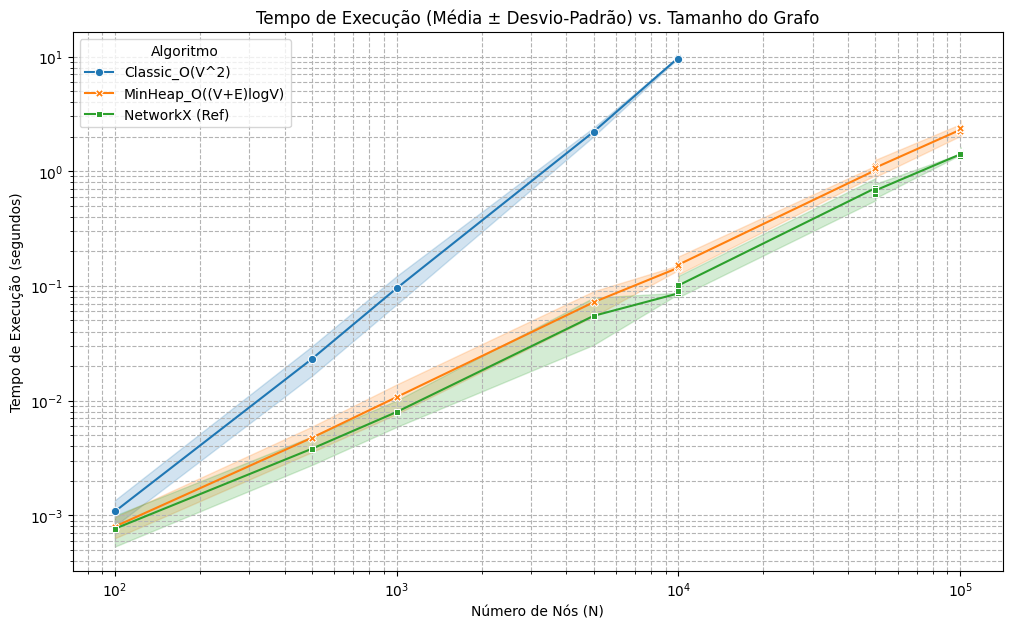

Gráfico de CO2 (SD) salvo em: resultados/co2_vs_tamanho_sd.png


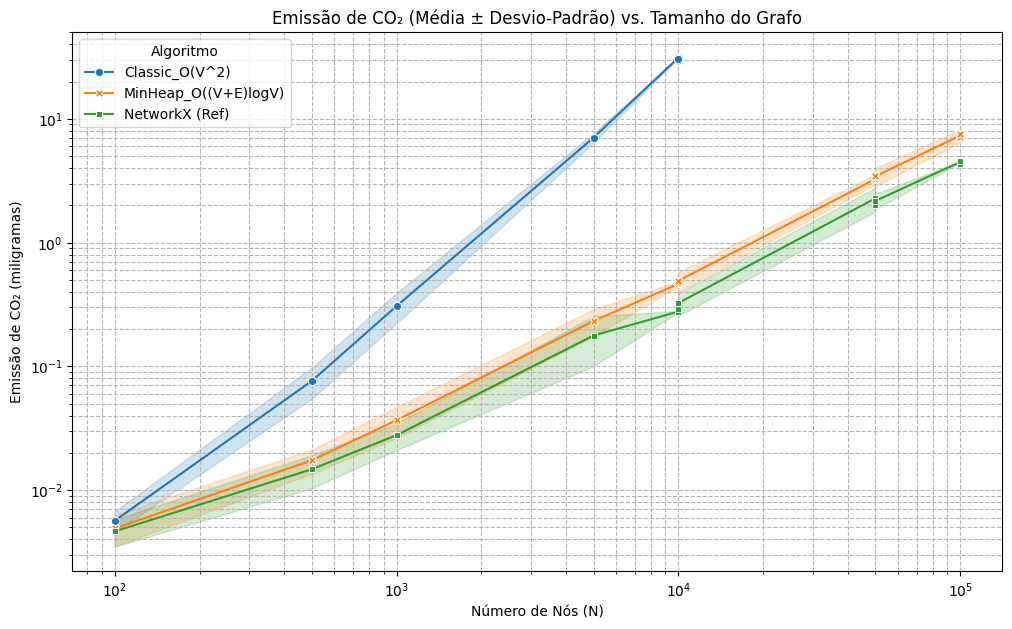

Gráfico de Tempo (Heap vs NX, SD) salvo em: resultados/tempo_vs_tamanho_rapidos_sd.png


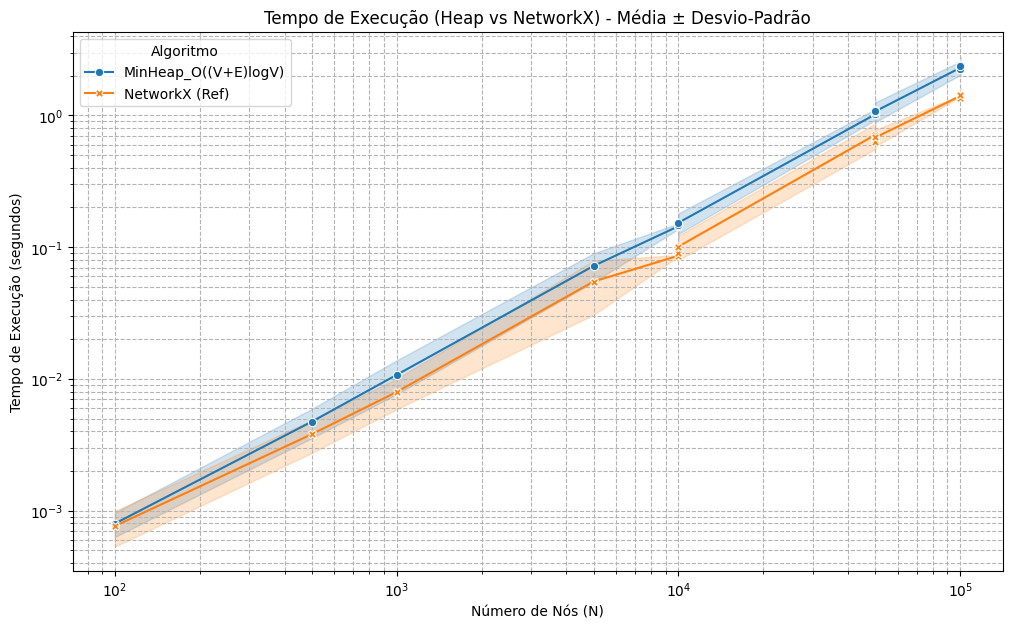


--- Análise Concluída ---


In [18]:
from google.colab import files
import pandas as pd

print("Por favor, faça o upload do seu arquivo 'resultados_brutos.csv'")
uploaded = files.upload()

# Pega o nome do arquivo que você acabou de enviar
csv_filename = list(uploaded.keys())[0]

if csv_filename != 'resultados_brutos.csv':
    print(f"Aviso: O arquivo foi salvo como '{csv_filename}'. Renomeando para 'resultados_brutos.csv' para o script.")
    # Renomeia o arquivo no ambiente do colab
    os.rename(csv_filename, 'resultados_brutos.csv')
    csv_filename = 'resultados_brutos.csv'


print(f"\nArquivo '{csv_filename}' carregado com sucesso!")

# --- Início da Análise ---

try:
    # Carrega o CSV para um DataFrame
    df_resultados_brutos = pd.read_csv(csv_filename)

    # Verifica se as colunas necessárias existem
    if 'co2_kg' not in df_resultados_brutos.columns:
        print("Coluna 'co2_kg' não encontrada. Verifique seu CSV.")
    if 'tempo_s' not in df_resultados_brutos.columns:
         print("Coluna 'tempo_s' não encontrada. Verifique seu CSV.")

    # A coluna co2_mg pode ou não já existir. Se não existir, crie-a.
    if 'co2_mg' not in df_resultados_brutos.columns and 'co2_kg' in df_resultados_brutos.columns:
         df_resultados_brutos['co2_mg'] = df_resultados_brutos['co2_kg'] * 1_000_000
         print("Coluna 'co2_mg' criada a partir de 'co2_kg'.")

    # 1. Calcular estatísticas (Média e Desvio-Padrão)
    print("\nCalculando estatísticas (Média e Desvio-Padrão)...")
    sumario = calcular_estatisticas(df_resultados_brutos)
    print("Tabela de Estatísticas Gerada (primeiras linhas):")

    print("\n" + "="*50)
    print("Tabela de Estatísticas Gerada (Média e Desvio-Padrão)")
    print("="*50)

    # Configura o pandas para mostrar todas as linhas e colunas
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000) # Deixa a tabela mais larga

    print(sumario) # Imprime a tabela COMPLETA

    # Reseta as opções para o padrão (para não afetar outras células)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    print("="*50)

    # 2. Gerar gráficos com Desvio-Padrão
    print("\nGerando gráficos com Desvio-Padrão...")
    gerar_graficos_com_desvio_padrao(df_resultados_brutos)

    print("\n--- Análise Concluída ---")

except NameError:
    print("\nERRO: Parece que a 'Célula 8 (Atualizada)' não foi executada.")
    print("Por favor, execute a célula que define as funções 'calcular_estatisticas' e 'gerar_graficos_com_desvio_padrao' e tente novamente.")
except FileNotFoundError:
    print(f"\nERRO: Arquivo '{csv_filename}' não encontrado após o upload. Tente novamente.")
except Exception as e:
    print(f"\nUm erro inesperado ocorreu: {e}")

Esta é uma célula de demonstração e teste.

In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import time
from codecarbon import EmissionsTracker

# Inicia o rastreador de emissões
tracker = EmissionsTracker(output_dir=".", save_to_file=False, log_level="error")
tracker.start()

# Mede o tempo total de geração e plotagem
start = time.time()

# Cria um grafo aleatório com 10 nós e probabilidade 0.3
G = nx.gnp_random_graph(n=100, p=0.3, seed=42)

# Adiciona pesos (inteiros entre 1 e 10)
for u, v in G.edges():
    G[u][v]['weight'] = random.randint(1, 10)

# Mostra algumas arestas com peso
for u, v, data in list(G.edges(data=True))[:5]:
    print(f"Aresta {u}-{v}, peso = {data['weight']}")

# Visualização com pesos nas arestas
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.show()

# Finaliza o cálculo de tempo e emissões
end = time.time()
elapsed = end - start
emissions = tracker.stop()

print(f"Tempo total de execução: {elapsed:.3f} segundos")
print(f"Pegada de carbono estimada: {emissions:.8f} kg de CO₂e")